In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from skan import Skeleton, summarize
import skimage

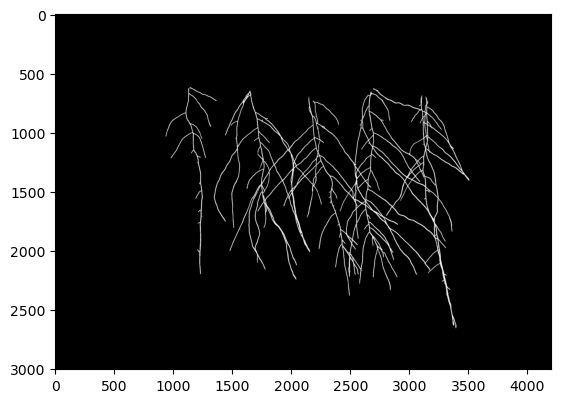

In [51]:
mask_path = ('/Users/work_uni/Documents/GitHub/AIxPlant_Science/overlapping_roots/mask_no_noicce.png')
mask = cv2.imread(mask_path, 0)
mask_seeding_position_label = skimage.measure.label(mask).astype('uint8')
_, template_segmented, stats, _ = cv2.connectedComponentsWithStats(mask_seeding_position_label)
template_segmented = skimage.morphology.remove_small_objects(template_segmented, np.mean(stats[1:,4]))
template_segmented = (template_segmented * 255).astype(np.uint8)
template_segmented = cv2.cvtColor(template_segmented, cv2.COLOR_GRAY2BGR)

plt.imshow(template_segmented)

In [50]:
template_segmented.shape

(3006, 4202)

In [56]:
stats_filtered = stats[(stats[:,1] >= 444) & (stats[:,1] <= 773)]
np.median(stats_filtered[1:,4]) * len(stats_filtered[1:,4])

1197.0

In [5]:
template = cv2.imread("seeding_template.tif",0)
# trying disctontinuity
# mask = cv2.imread('overlapped_w_discontinuityapplied.png',0)[33:-33,75:-75]
# mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
# mask = (mask * 255).astype('uint8')

mask_path = ('/Users/work_uni/Documents/GitHub/AIxPlant_Science/overlapping_roots/mask_no_noicce.png')
mask = cv2.imread(mask_path)
# mask = cv2.imread('/Users/work_uni/Documents/GitHub/AIxPlant_Science/overlapping_roots/mask_no_noicce.png')

template_reshaped = np.zeros_like(mask)

mask_seeding_position = cv2.resize(template, (mask.shape[1], mask.shape[0]))
mask_seeding_position[mask_seeding_position < 200] = 0
mask_seeding_position[mask_seeding_position != 0] = 255

mask_seeding_position_label = skimage.measure.label(mask_seeding_position).astype('uint8')
_, template_segmented, stats, _ = cv2.connectedComponentsWithStats(mask_seeding_position_label)

plants = []

for segment in stats[1::]:
    mid_x = (segment[0] * 2 + segment[2]) // 2
    mid_y = (segment[1] * 2 + segment[3]) // 2
    
    plants.append([segment[1],segment[1]+segment[3], segment[0], segment[0]+segment[2]])
    
    template_reshaped = cv2.circle(template_reshaped,(mid_x,mid_y), 25, (255,255,255), -1)

# min_x, max_x = 1000, -1
# min_y, max_y = 1000, -1
# 
# 
# for plant in plants:
#     y_min, y_max, x_min, x_max = plant
#     min_x = min(min_x, x_min)
#     max_x = max(max_x, x_max)
#     min_y = min(min_y, y_min)
#     max_y = max(max_y, y_max)
# 
# zoom_seed = [[min_x, max_x],[min_y, max_y]]

In [6]:
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
mask_skeleton = skimage.morphology.skeletonize(mask)
mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
mask_branch = summarize(Skeleton(mask_skeleton))

source_nodes = mask_branch['node-id-src'].unique()
distance_nodes = mask_branch['node-id-dst'].unique()

starting_nodes = []

for node in source_nodes:
    if node not in distance_nodes:
        starting_nodes.append(node)

print(starting_nodes)

start_node_locations = [[],[],[],[],[]]

for node in starting_nodes:
    x = mask_branch[mask_branch['node-id-src'] == node]['image-coord-src-1'].iloc[0]
    y = mask_branch[mask_branch['node-id-src'] == node]['image-coord-src-0'].iloc[0]
    
    for i, plant in enumerate(plants):
        
        y1, y2, x1, x2 = plant
        
        if x1 < x and x2> x and y1 < y and y2 > y:
            
            start_node_locations[i].append([x,y])
            
            # mask = cv2.circle(mask, (x, y), 10, (0, 255, 0), -1)
print(start_node_locations)
starting_nodes_coordinates = []

for i, nodes in enumerate(start_node_locations):
    x, y = 0, 0
    if len(nodes) == 1:
        x, y = nodes[0]
        y1, y2, x1, x2 = plants[i]
        mid_point_x = (x1 + x2) // 2
        mid_point_y = (y1 + y2) // 2
        distance = np.sqrt((mid_point_x - x) ** 2 + (mid_point_y - y) ** 2)
    else:
        y1, y2, x1, x2 = plants[i]
        mid_point_x = (x1 + x2) // 2
        mid_point_y = (y1 + y2) // 2
        distance = 1000
        
        for node in nodes:
            x_n, y_n = node
            distance_n = np.sqrt((mid_point_x - x_n) ** 2 + (mid_point_y - y_n) ** 2)
            if distance_n < distance:
                x, y = x_n, y_n
                distance = distance_n
            
    # mask = cv2.circle(mask, (x, y), 10, (0, 255, 0), -1)
    starting_nodes_coordinates.append((x,y, distance))

print(starting_nodes_coordinates)
for i, nodes in enumerate(start_node_locations):
    
    x, y, distance = starting_nodes_coordinates[i]
    
    if len(nodes) > 1:
        for node in nodes:
            x_n, y_n = node
            distance_n = np.sqrt((x - x_n) ** 2 + (y - y_n) ** 2)
            if distance_n < distance:
                mask = cv2.line(mask, (x,y), (x_n, y_n), (255, 255, 255), 5)

[0, 38, 46, 98, 126, 231, 234, 263, 392, 394, 396, 436, 437, 452, 489, 546, 635, 668, 681, 713, 1169, 1205, 1285, 1310, 1369, 1379, 1486, 1522, 2004, 2354, 3204, 5464, 5675, 5936, 7287, 7343, 8971, 9009, 16332, 18833, 19408, 24697, 25148, 28801, 32837, 32853, 35056, 35108, 36181, 36352, 36577, 38477, 39051, 39116, 40824, 41769, 42236, 42541, 43436, 43581, 43644]
[[[1147, 619]], [[1564, 502], [1651, 618], [1629, 619], [1643, 627], [1644, 629], [1658, 634], [1653, 651], [1500, 698], [1675, 711]], [[2150, 699], [2193, 703], [2178, 709], [2180, 735]], [[2707, 452], [2695, 627], [2722, 639], [2729, 654], [2728, 655], [2680, 658]], [[3225, 465], [3108, 690], [3141, 702]]]
[(1147, 619, 123.4908903522847), (1629, 619, 66.91038783328041), (2150, 699, 102.42070103255493), (2695, 627, 56.302753041036986), (3141, 702, 101.76934705499491)]


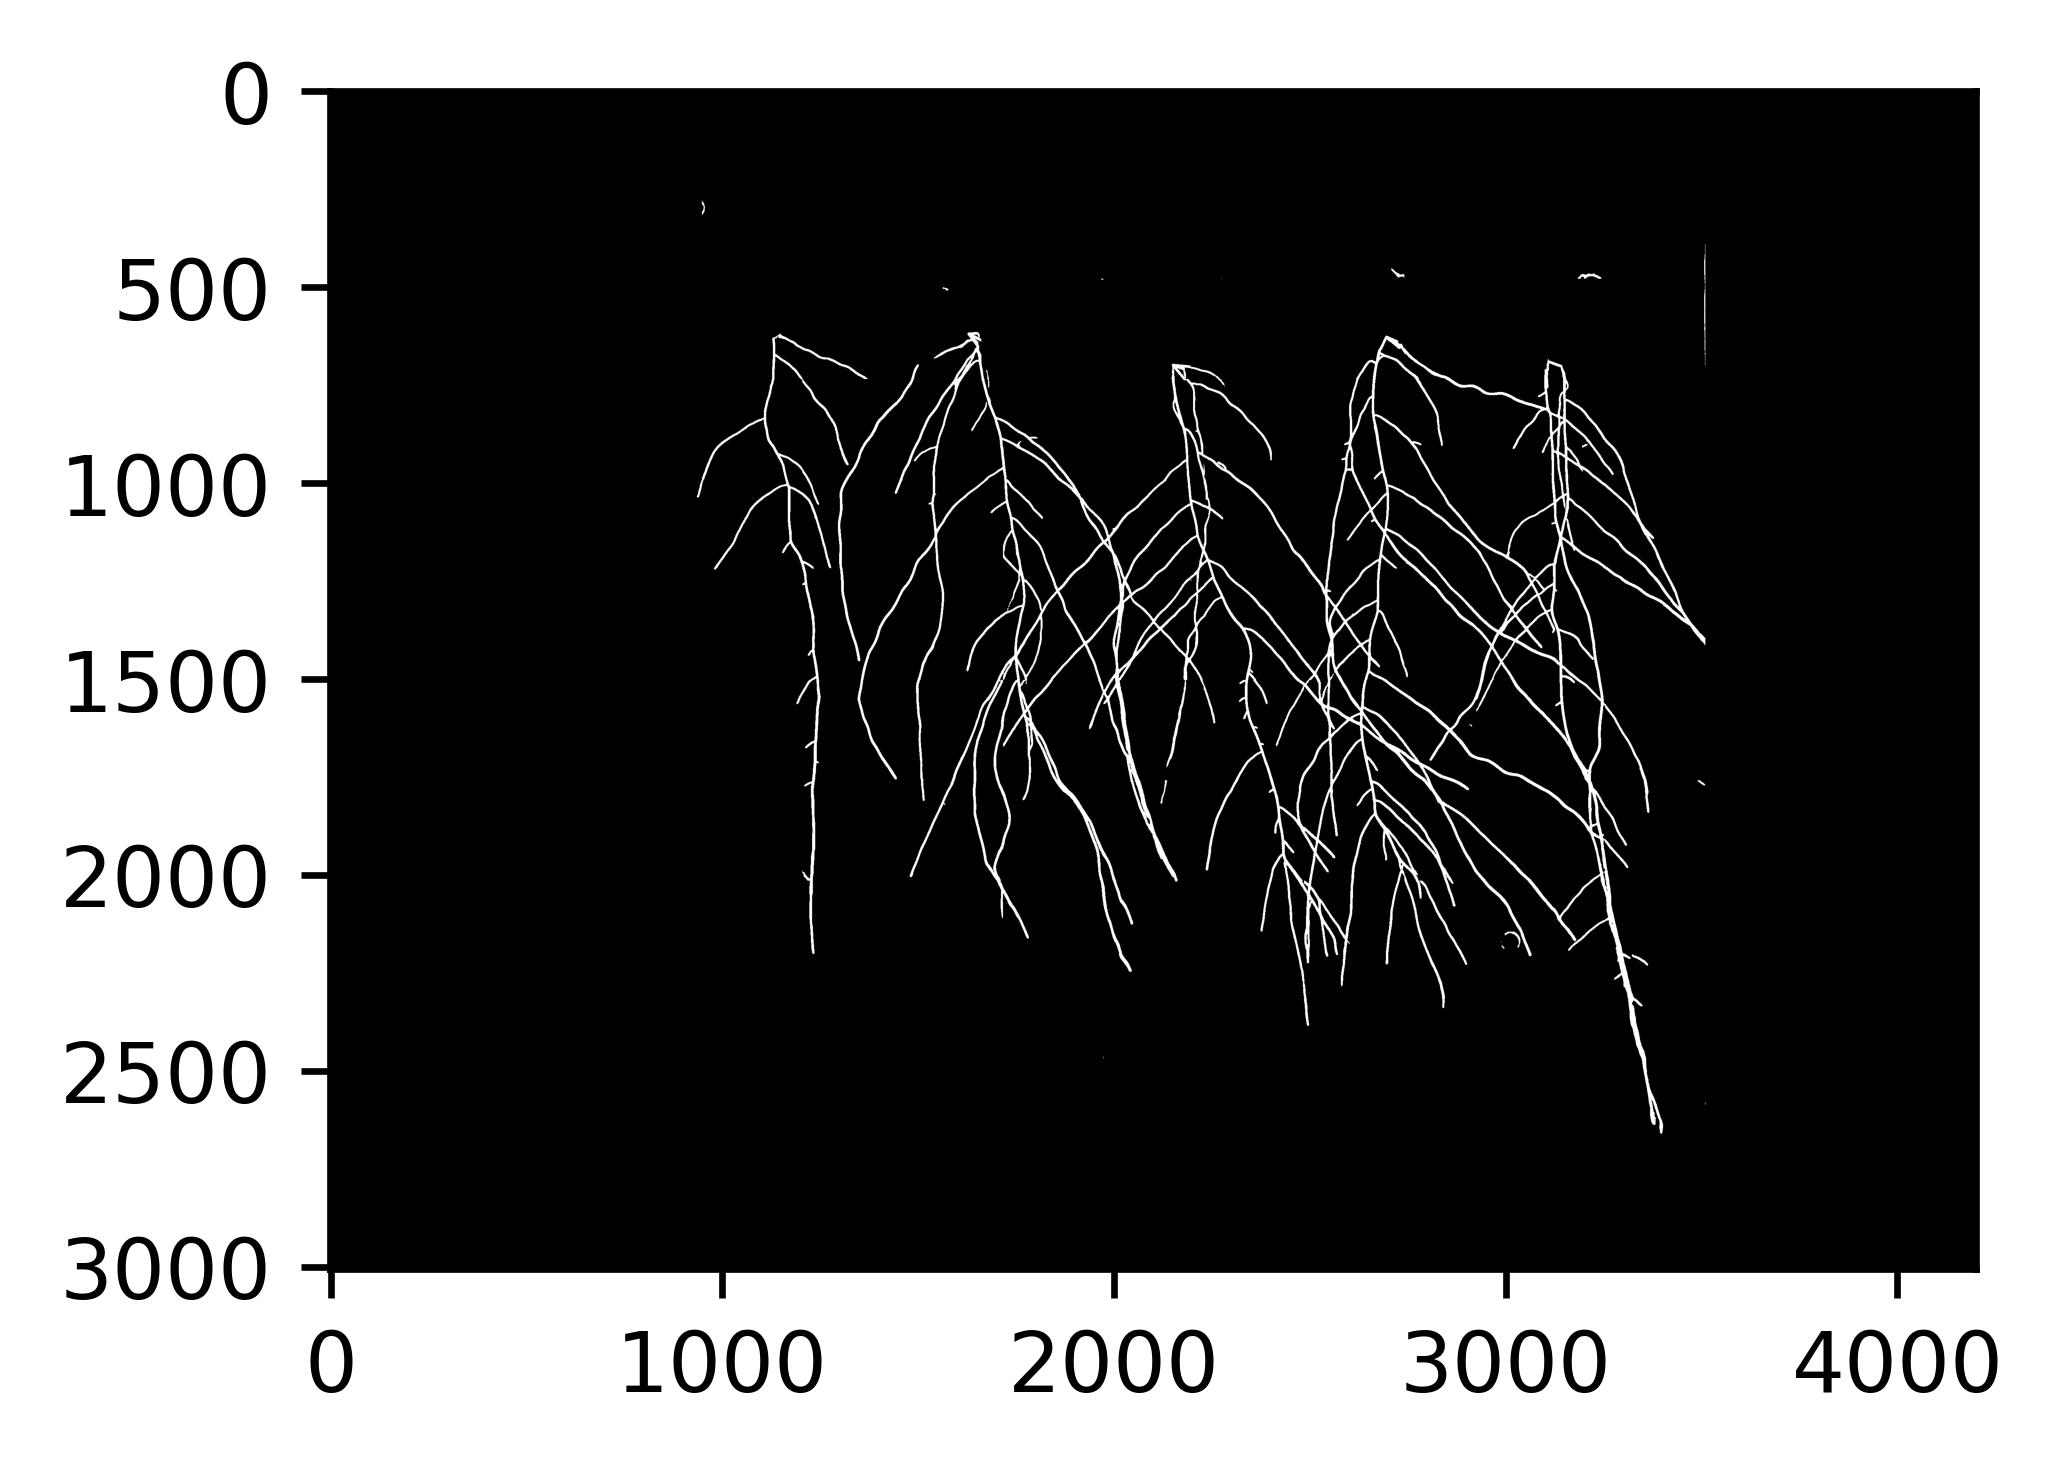

In [7]:
fig = plt.figure(figsize=(3.54, 3.54), dpi=600)
plt.imshow(mask)

In [8]:
starting_nodes_coordinates

[(1147, 619, 123.4908903522847),
 (1629, 619, 66.91038783328041),
 (2150, 699, 102.42070103255493),
 (2695, 627, 56.302753041036986),
 (3141, 702, 101.76934705499491)]

In [9]:
plants_subsets = []
for i in range(1, len(plants)+1):
    if i < len(plants):
        y1, y2, x1, x2 = plants[i-1]
        _, _, x_right_bound, _ = plants[i]
        plants_subsets.append([y1,x1,x_right_bound])
    elif i == len(plants):
        y1, y2, x1, x2 = plants[i-1]
        plants_subsets.append([y1,x1, x2])

In [10]:
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
mask = ((mask > 0) * 1).astype('uint8')
mask_skeleton = skimage.morphology.skeletonize(mask)
# mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB) #!
mask_branch = summarize(Skeleton(mask_skeleton))

# G_mask = nx.from_pandas_edgelist(mask_branch, source='node-id-src', target='node-id-dst', edge_attr='branch-distance')

source_nodes = mask_branch['node-id-src'].unique()
distance_nodes = mask_branch['node-id-dst'].unique()

starting_nodes = []

for node in source_nodes:
    if node not in distance_nodes:
        starting_nodes.append(node)


start_node_locations = [[],[],[],[],[]]

for node in starting_nodes:
    x = mask_branch[mask_branch['node-id-src'] == node]['image-coord-src-1'].iloc[0]
    y = mask_branch[mask_branch['node-id-src'] == node]['image-coord-src-0'].iloc[0]
    
    for i, plant in enumerate(plants):
        
        y1, y2, x1, x2 = plant
        
        if x1 < x and x2> x and y1 < y and y2 > y:
            
            start_node_locations[i].append([x,y])

starting_nodes_coordinates = []

for i, nodes in enumerate(start_node_locations):
    x, y = -1, -1
    if len(nodes) == 1:
        x, y = nodes[0]
        y1, y2, x1, x2 = plants[i]
        mid_point_x = (x1 + x2) // 2
        mid_point_y = (y1 + y2) // 2
        distance = np.sqrt((mid_point_x - x) ** 2 + (mid_point_y - y) ** 2)
    else:
        y1, y2, x1, x2 = plants[i]
        mid_point_x = (x1 + x2) // 2
        mid_point_y = (y1 + y2) // 2
        distance = 1000
        
        for node in nodes:
            x_n, y_n = node
            distance_n = np.sqrt((mid_point_x - x_n) ** 2 + (mid_point_y - y_n) ** 2)
            if distance_n < distance:
                x, y = x_n, y_n
                distance = distance_n
            
    # mask = cv2.circle(mask, (x, y), 10, (0, 255, 0), -1)
    starting_nodes_coordinates.append((x,y, distance))

In [11]:
starting_nodes_coordinates

[(1147, 619, 123.4908903522847),
 (1630, 619, 67.89698078707183),
 (2151, 699, 102.88342918079665),
 (2695, 632, 58.180752831155424),
 (3108, 685, 105.41821474489122)]

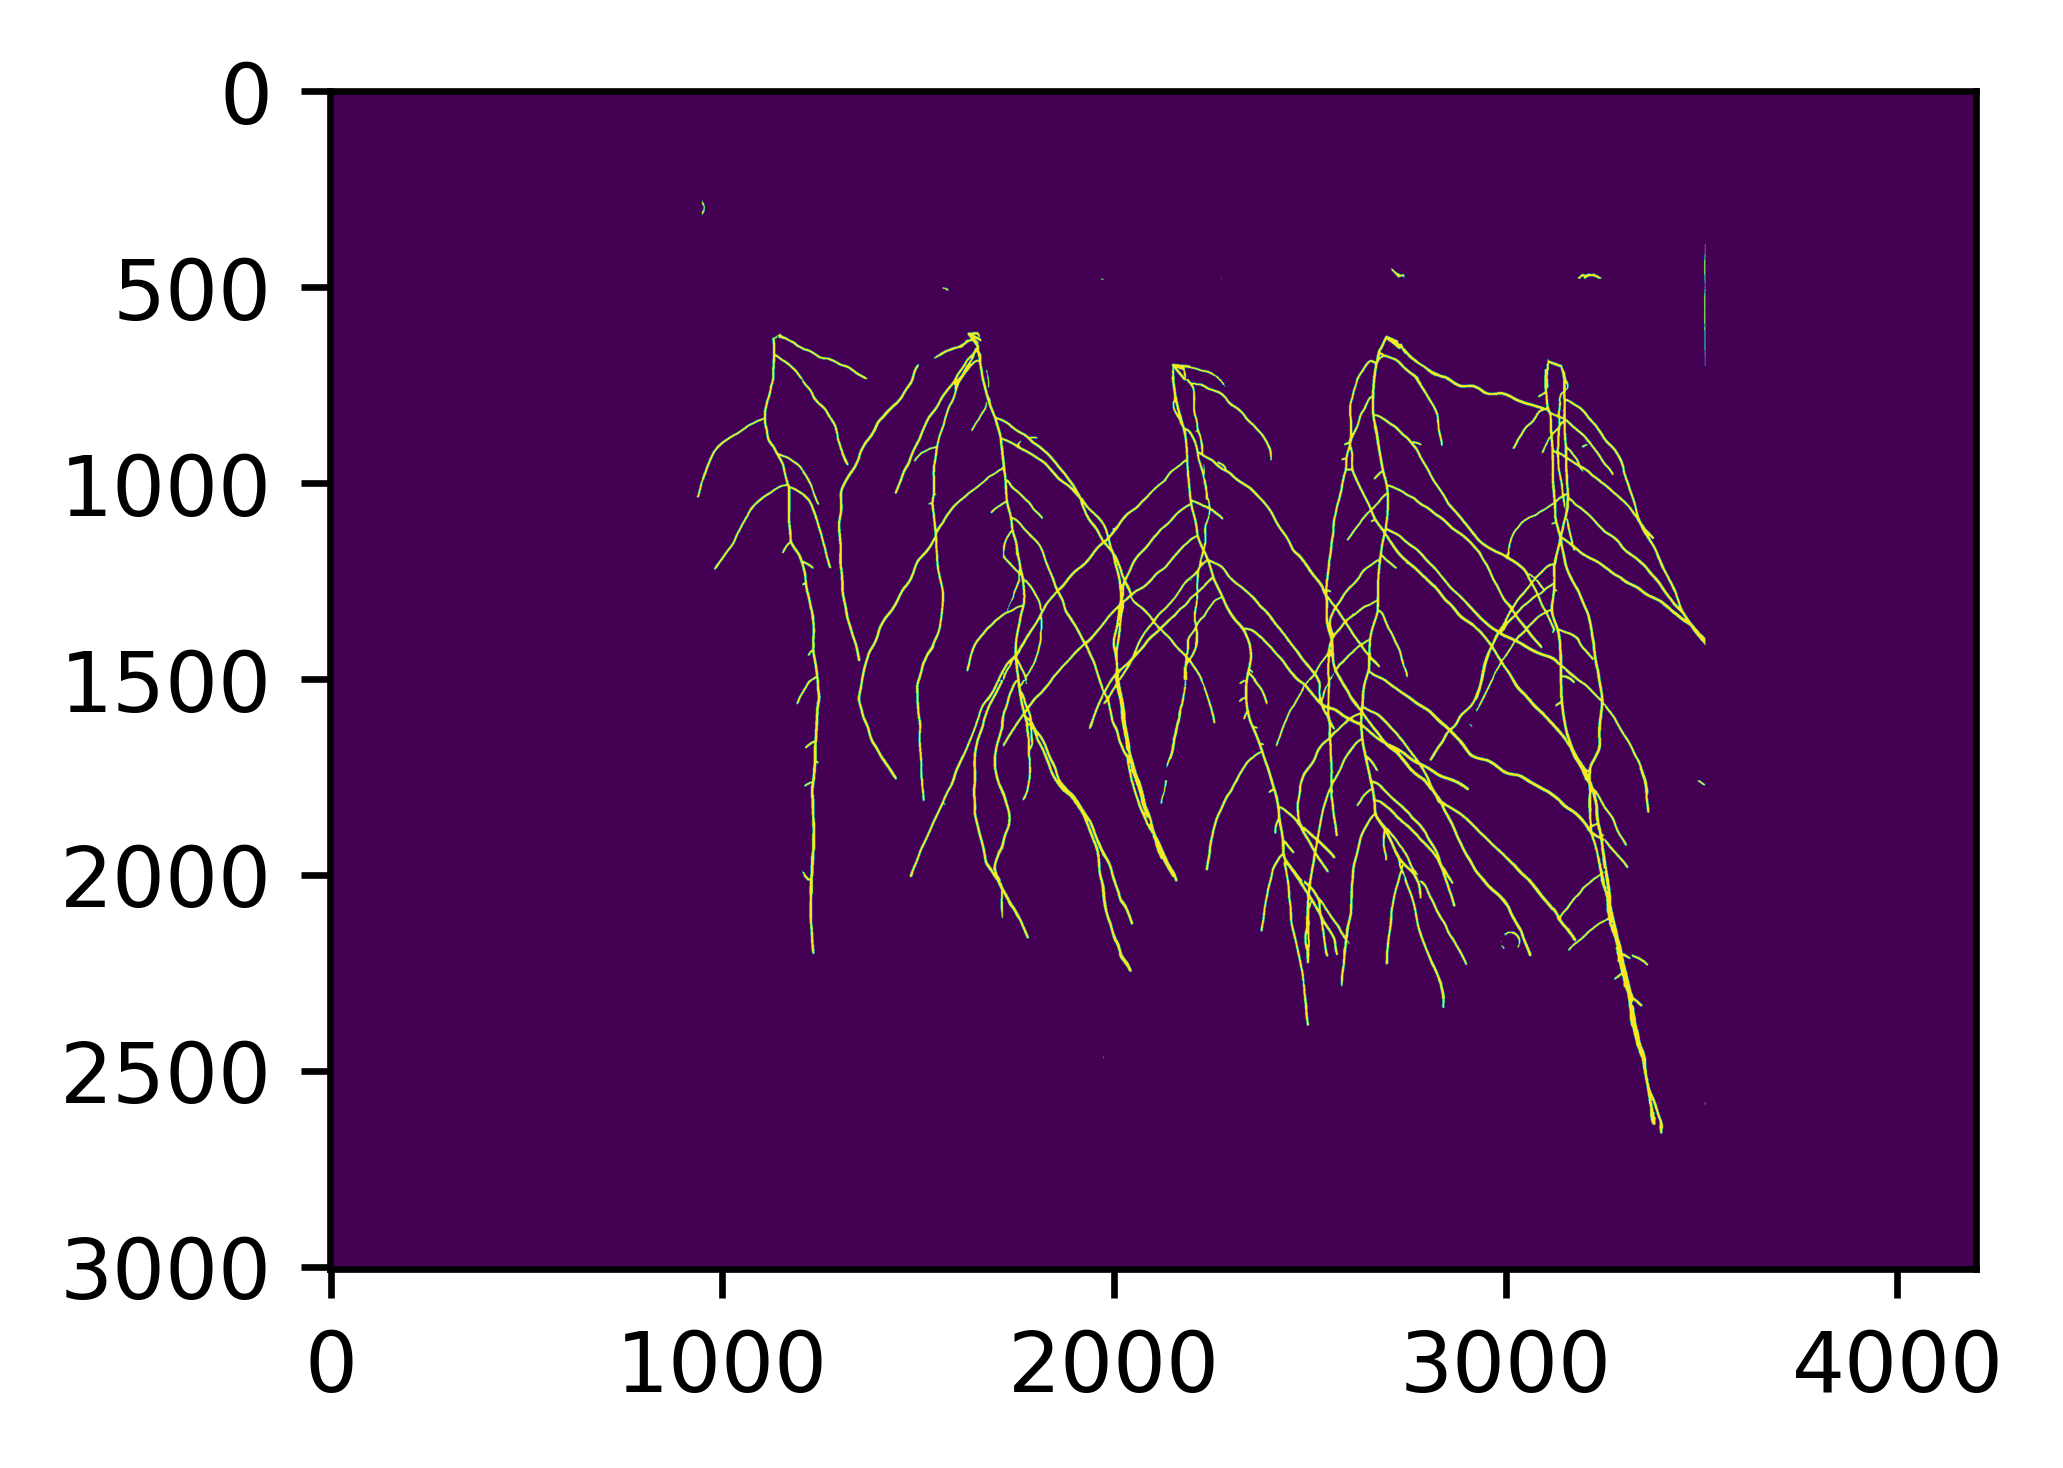

In [12]:
fig = plt.figure(figsize=(3.54, 3.54), dpi=600)
plt.imshow(mask)

In [13]:
mask_for_subsets = cv2.imread(mask_path)
mask_drawwing = cv2.imread(mask_path)
# mask_drawwing = cv2.imread(mask_path,0)
# mask_drawwing = cv2.cvtColor(mask_drawwing, cv2.COLOR_GRAY2RGB)

In [14]:
import math
def calculate_slope(x1, y1, x2, y2):
    m1 = 0
    m2 = (y2-y1)/(x2-x1)
    
    tan_theta = abs((m2 - m1) / (1 + m1 * m2))

    # Calculate the angle in radians
    theta_radians = math.atan(tan_theta)
    
    # Convert the angle to degrees
    theta_degrees = math.degrees(theta_radians)
    
    return  theta_degrees

In [15]:
def draw_root(yx, image, offset_x, offset_y, colour):
    
    for coords in yx:
        image[coords[0] + offset_y, coords[1] + offset_x] = colour
        
    return image

In [16]:
distances = []
skeleton_drawing = cv2.imread(mask_path)
primary_r = np.zeros_like(skeleton_drawing)
full_skeleton = np.zeros_like(skeleton_drawing)

print(mask.shape)
for i, plant in enumerate(plants_subsets):
    print(plant)
    if i != 4:
        mask_subset = mask[plant[0]::, plant[1]:plant[2]]
    else:
        mask_subset = mask[plant[0]::, plant[1]::]
    
    mask_subset_skeleton = skimage.morphology.skeletonize(mask_subset)
    mask_subset_skeleton_ob = Skeleton(mask_subset_skeleton)
    mask_subset_branch = summarize(mask_subset_skeleton_ob)
    
    offset_y, _, offset_x, _ = plants[i]
    start_x, start_y, _ = starting_nodes_coordinates[i]
    print(starting_nodes_coordinates[i])
    start_x -= offset_x
    start_y -= offset_y
    
    unique_last_nodes = mask_subset_branch['node-id-dst'].unique()[::-1]
    end_points = []
    for item in unique_last_nodes:
        if item not in mask_subset_branch['node-id-src'].unique():
            end_points.append(item)
    
    if len(mask_subset_branch[(mask_subset_branch['image-coord-src-0'] == start_y) & (mask_subset_branch['image-coord-src-1'] == start_x)]['node-id-src']) == 0:
        continue
    start_node_id = mask_subset_branch[(mask_subset_branch['image-coord-src-0'] == start_y) & (mask_subset_branch['image-coord-src-1'] == start_x)]['node-id-src'].iloc[0]
    
    G = nx.from_pandas_edgelist(mask_subset_branch, source='node-id-src', target='node-id-dst', edge_attr='branch-distance')
    last_node = max(G.nodes())
    
    un_sorted_nodes = list(G.nodes())
    sorted_nodes = sorted(un_sorted_nodes)
    
    node_count = -1
    distance = 0
    
    while distance == 0:

        node_count -= 1
        if nx.has_path(G, start_node_id, last_node):
            distance =  nx.dijkstra_path_length(G, start_node_id, last_node, weight='branch-distance')
        else:
            last_node = sorted_nodes[node_count]
        
    
    if distance!=0:
            
        path = nx.dijkstra_path(G, source=start_node_id, target=last_node, weight='branch-distance')
        
        for i in range(len(mask_subset_branch)):
            end_node = mask_subset_branch["node-id-dst"].iloc[i]
            yx = mask_subset_skeleton_ob.path_coordinates(i)
            
            full_skeleton = draw_root(yx, full_skeleton, offset_x, offset_y, (255, 255, 255))
           
            if end_node in path:
                primary_r = draw_root(yx, primary_r, offset_x, offset_y, (0, 255, 0))
            
    distances.append(distance)

(3006, 4202)
[444, 899, 1438]
(1147, 619, 123.4908903522847)
[444, 1438, 1978]
(1630, 619, 67.89698078707183)
[444, 1978, 2517]
(2151, 699, 102.88342918079665)
[444, 2517, 3055]
(2695, 632, 58.180752831155424)
[444, 3055, 3306]
(3108, 685, 105.41821474489122)


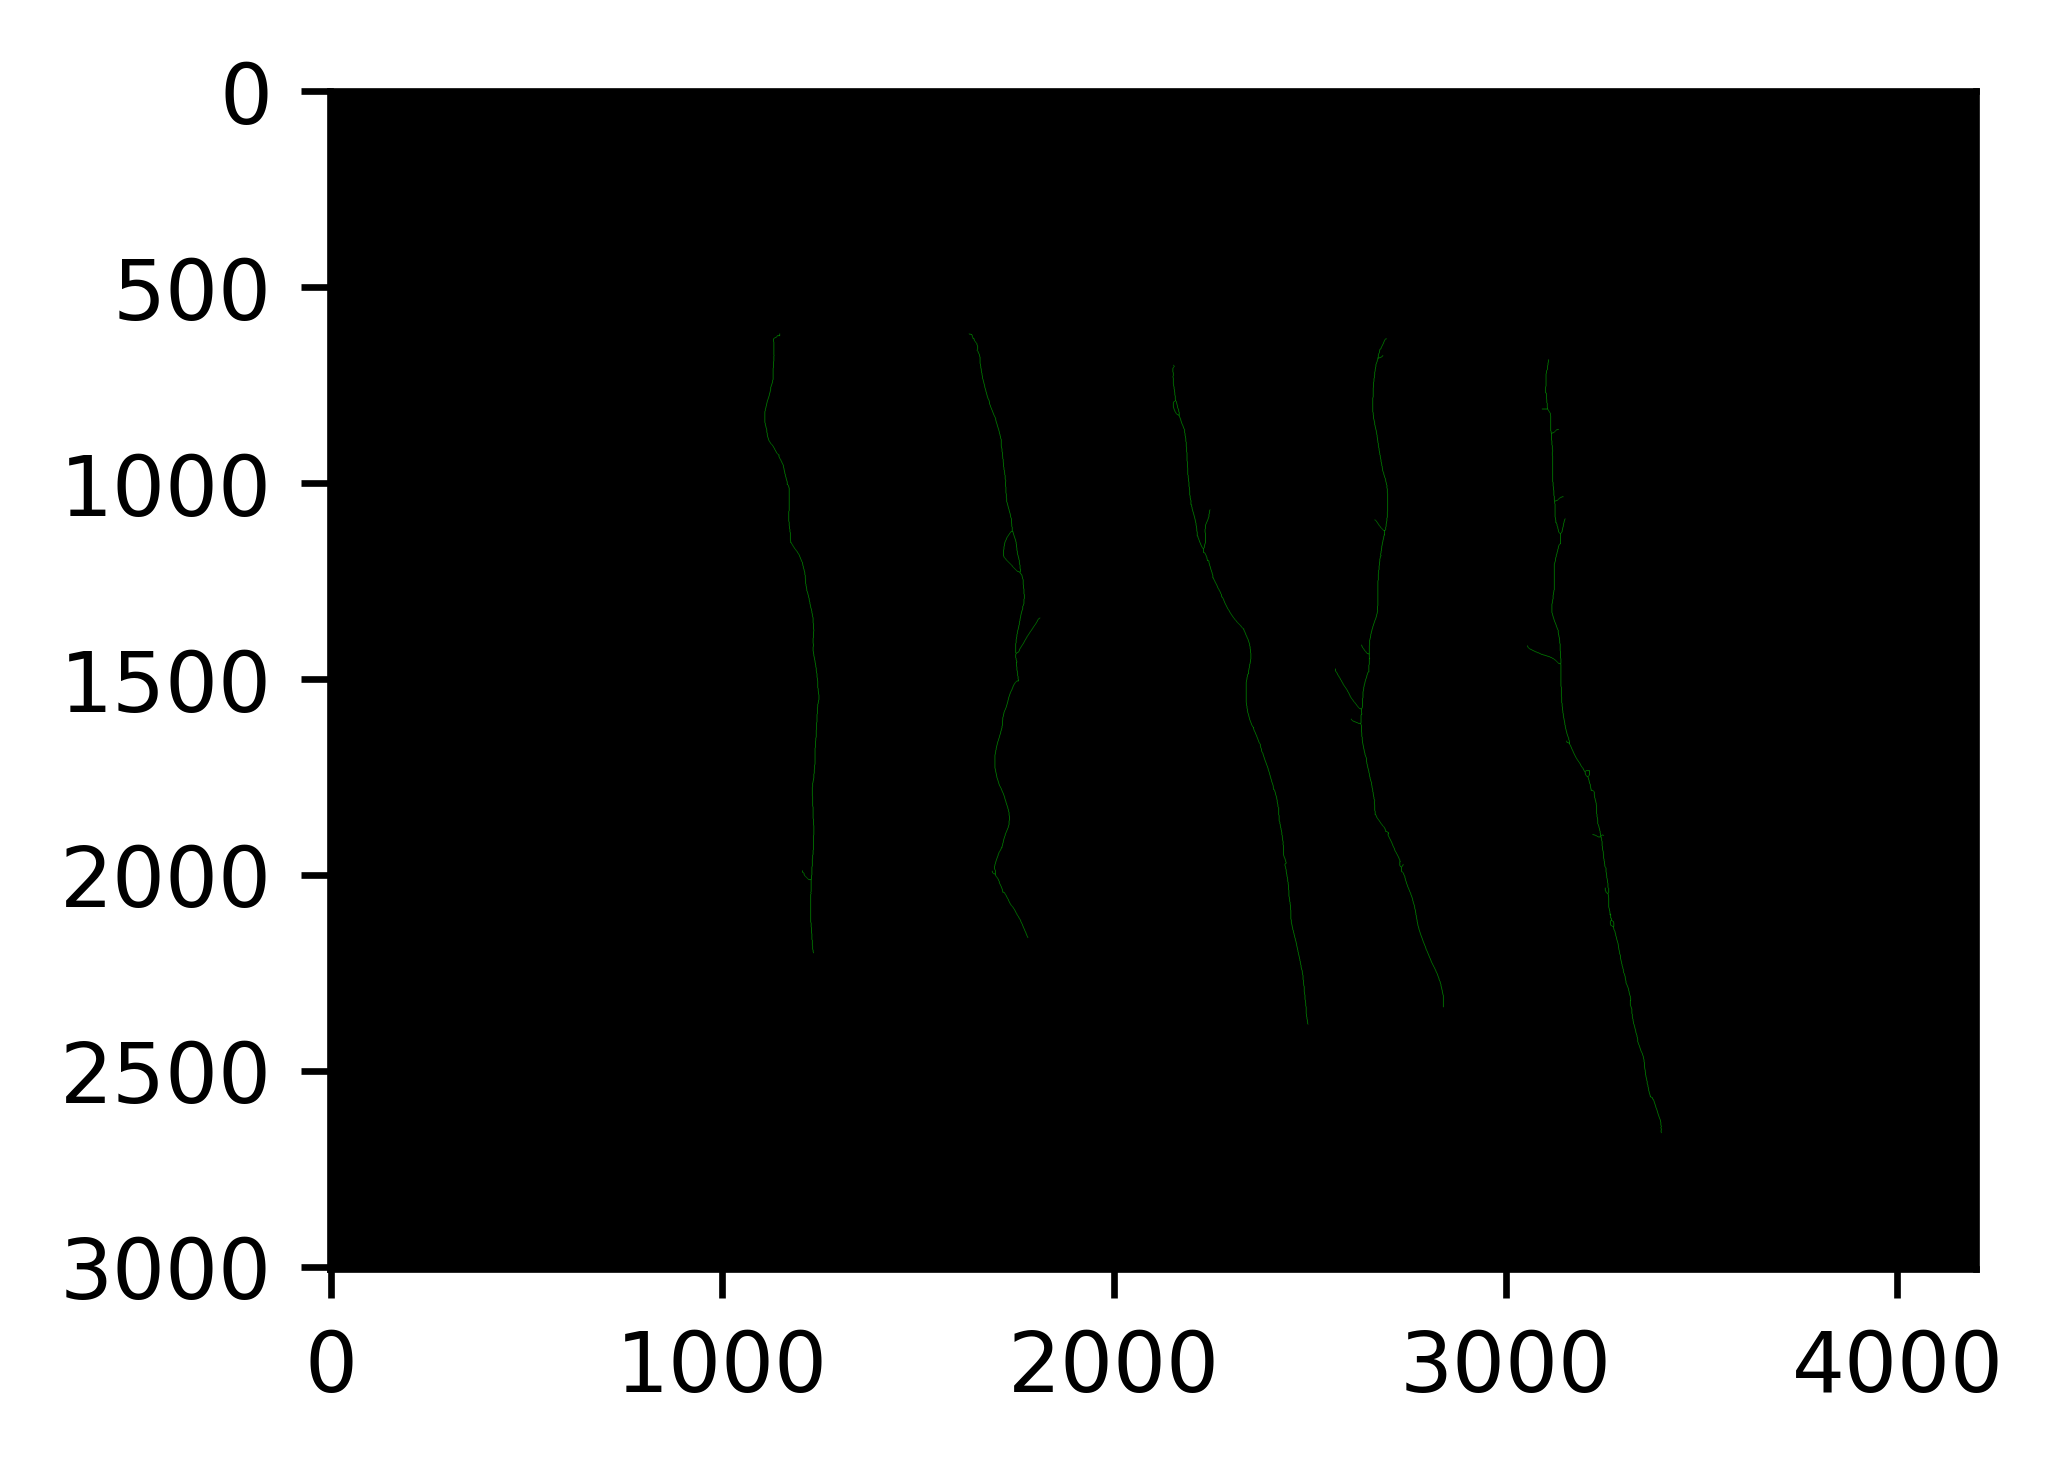

In [17]:
fig = plt.figure(figsize=(3.54, 3.54), dpi=600)
plt.imshow(primary_r)

3507
(0, 255, 255)
2707
(255, 255, 0)
3225
(0, 255, 255)
3224
(0, 255, 255)
3224
(0, 255, 255)
3202
(0, 255, 255)
3202
(0, 255, 255)
2273
(0, 0, 255)
1966
(255, 0, 255)
1564
(255, 0, 255)
1638
(255, 0, 255)
1147
(255, 0, 0)
1653
(255, 0, 255)
1653
(255, 0, 255)
1646
(255, 0, 255)
1646
(255, 0, 255)
2696
(255, 255, 0)
2696
(255, 255, 0)
2696
(255, 255, 0)
2697
(255, 255, 0)
1639
(255, 0, 255)
1644
(255, 0, 255)
1649
(255, 0, 255)
2677
(255, 255, 0)
1134
(255, 0, 0)
1638
(255, 0, 255)
1638
(255, 0, 255)
1657
(255, 0, 255)
3109
(0, 255, 255)
3508
(0, 255, 255)
2668
(255, 255, 0)
1500
(255, 0, 255)
1631
(255, 0, 255)
2155
(0, 0, 255)
2157
(0, 0, 255)
2157
(0, 0, 255)
2175
(0, 0, 255)
2175
(0, 0, 255)
1675
(255, 0, 255)
2179
(0, 0, 255)
3103
(0, 255, 255)
1598
(255, 0, 255)
1598
(255, 0, 255)
1598
(255, 0, 255)
3150
(0, 255, 255)
3150
(0, 255, 255)
2198
(0, 0, 255)
2198
(0, 0, 255)
2282
(0, 0, 255)
3149
(0, 255, 255)
3148
(0, 255, 255)
3148
(0, 255, 255)
3100
(0, 255, 255)
2660
(255, 255, 0

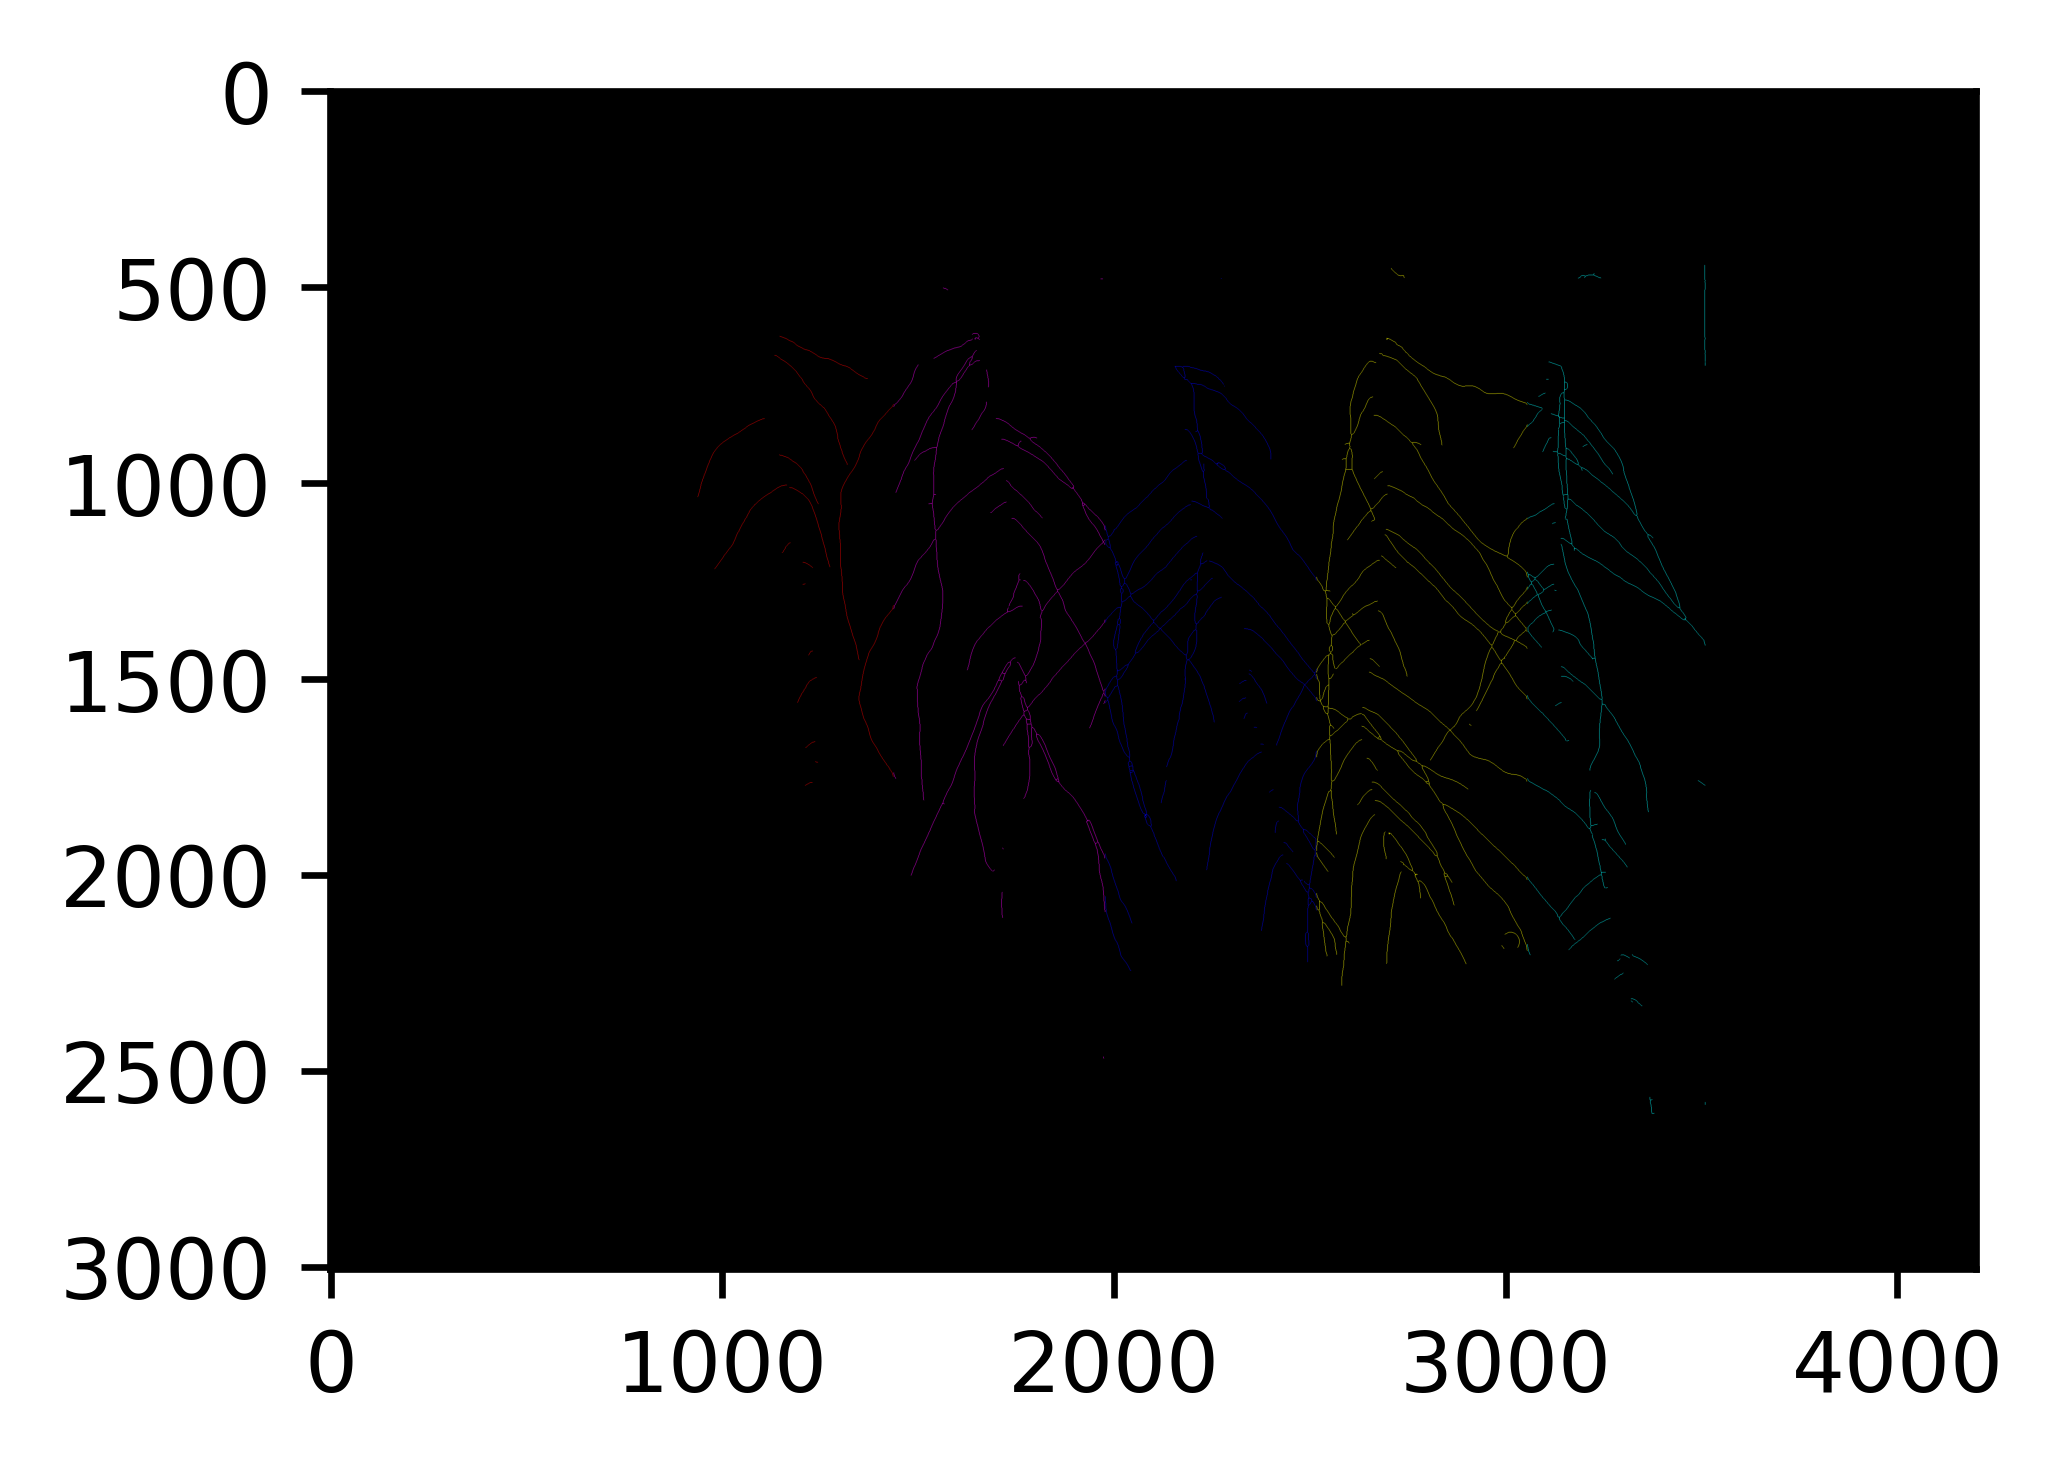

In [18]:
primary_r_bin = cv2.cvtColor(primary_r, cv2.COLOR_RGB2GRAY)
full_skeleton = cv2.cvtColor(full_skeleton, cv2.COLOR_RGB2GRAY)

bin = cv2.bitwise_xor(primary_r_bin, full_skeleton)
lateral_r = ((bin > 250)*255).astype('uint8')

lateral_skeleton = Skeleton(lateral_r)
lateral_branch = summarize(lateral_skeleton)

lateral_r = cv2.cvtColor(lateral_r, cv2.COLOR_GRAY2RGB)

colours = [
    (255, 0, 0),
    (255, 0, 255),
    (0, 0, 255),
    (255, 255, 0),
    (0, 255, 255)
]

segmented_roots_p1 = np.zeros_like(lateral_r)

G_lat = nx.from_pandas_edgelist(lateral_branch, source='node-id-src', target='node-id-dst', edge_attr='branch-distance')

for i in range(len(lateral_branch)-1):
    start_node = lateral_branch['node-id-src'].iloc[i]
    end_node = lateral_branch['node-id-dst'].iloc[i]
    
    path = nx.dijkstra_path(G_lat, start_node, end_node)
    
    
    if len(path) == 2:
        
        colour = []
        
        x = lateral_branch['image-coord-src-1'].iloc[i]
        print(x)
        
        plants_subsets_test = [900, 1438, 1978, 2517, 3055]
        plants_subsets_test2 = [1150, 1689, 2228, 3000, 3500]
        plants_subsets_test3 = [1438, 1978, 2517, 3055, 4000]


        
        for j, subset in enumerate(plants_subsets_test3):
            
            if x < subset and colour == []:
                
                colour = colours[j]
        if colour == []:
            colour = colours[-1]
        print(colour)
                
        for k in range(len(lateral_branch)):
            s_node = lateral_branch["node-id-src"].iloc[k]
            e_node = lateral_branch["node-id-dst"].iloc[k]
            yx = lateral_skeleton.path_coordinates(k)
            
            if start_node in path and e_node in path:
                
                segmented_roots_p1 = draw_root(yx, segmented_roots_p1, 0, 0, colour)
                        
            
    
    # x = lateral_branch['image-coord-src-1'].iloc[i]
    # y = lateral_branch['image-coord-src-0'].iloc[i]
    # 
    # lateral_r = cv2.circle(lateral_r, (x,y), 5, (0,255,0), -1)
    # 
    # x = lateral_branch['image-coord-dst-1'].iloc[i]
    # y = lateral_branch['image-coord-dst-0'].iloc[i]
    # 
    # lateral_r = cv2.circle(lateral_r, (x,y), 5, (255,0,0), -1)
fig = plt.figure(figsize=(3.54,3.54), dpi=600)
plt.imshow(segmented_roots_p1, cmap='grey')

In [19]:

img = cv2.imread('/Users/work_uni/Documents/GitHub/AIxPlant_Science/overlapping_roots/input_images/000_43-18-ROOT1-2023-08-08_pvdCherry_OD001_Col0_01-Fish Eye Corrected.png')
result = cv2.addWeighted(img, 0.5, primary_r, 0.75, 0)
result = cv2.addWeighted(result, 1, segmented_roots_p1, 0.75, 0)
# cv2.imwrite('segmentation_trialtest3.png', result)

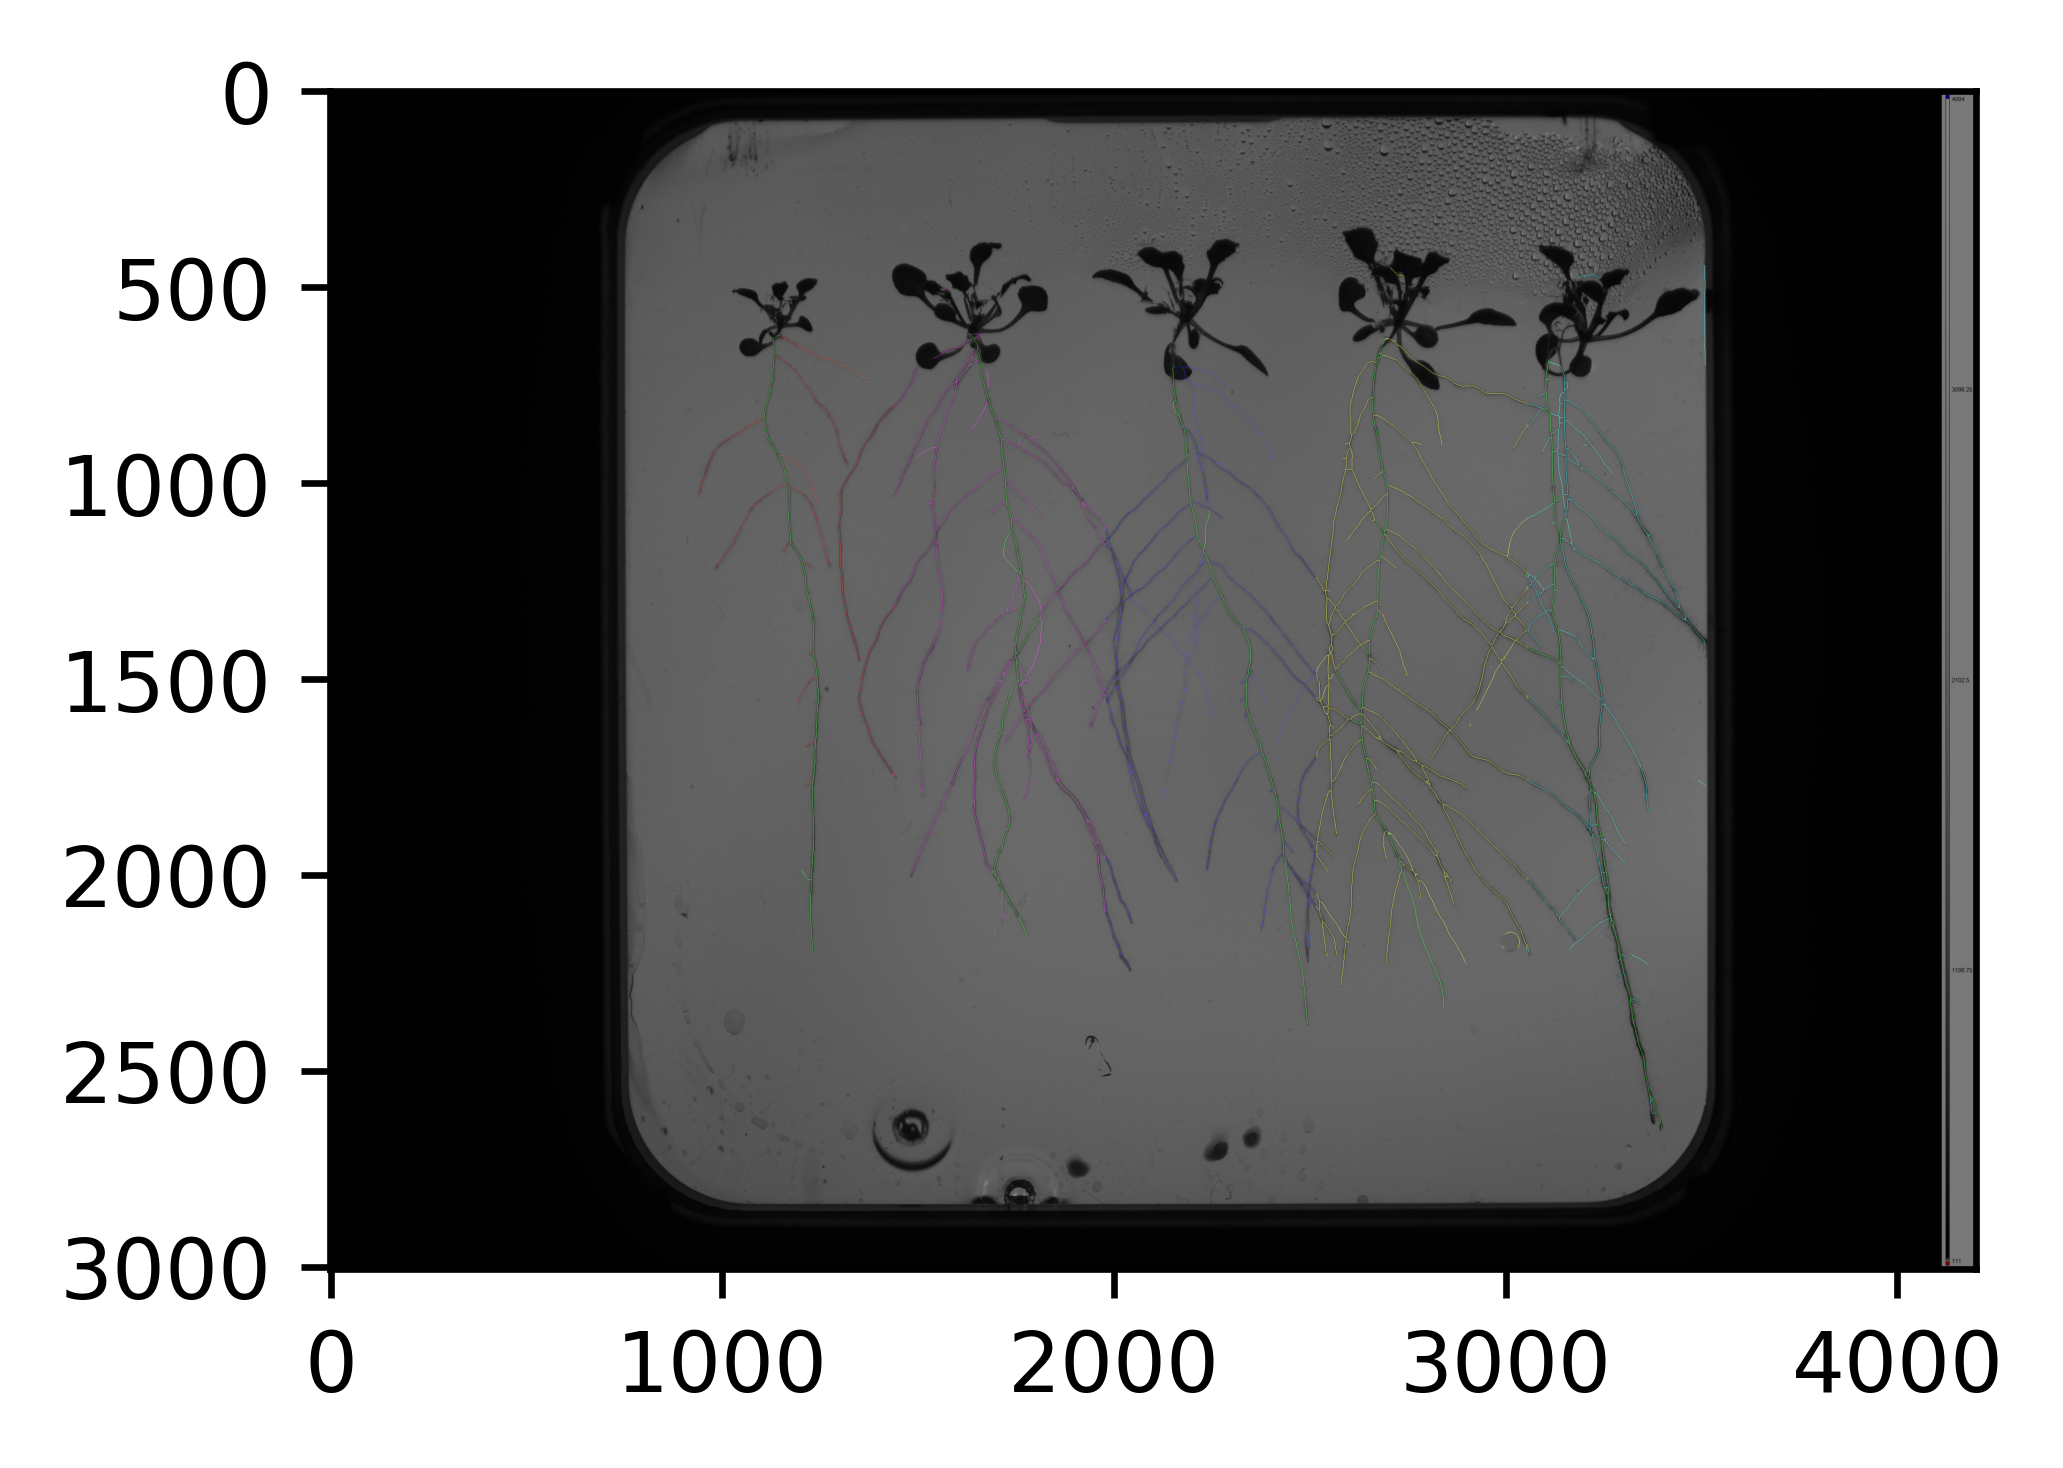

In [20]:
fig = plt.figure(figsize=(3.54,3.54), dpi=600)
plt.imshow(result, cmap='grey')

In [21]:
cv2.imwrite('segmentation_trial.png', result)

True